# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [7]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', quotechar='"')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';', quotechar='"')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows)
print('Shape of Udacity_AZDIAS_Subset.csv : {:,} x {} \n'.format(
    azdias.shape[0], azdias.shape[1]))
print('Shape of AZDIAS_Feature_Summary.csv : {:,} x {}'.format(
    feat_info.shape[0], feat_info.shape[1]))

Shape of Udacity_AZDIAS_Subset.csv : 891,221 x 85 

Shape of AZDIAS_Feature_Summary.csv : 85 x 4


In [4]:
# Print the fir few rows of azdias
print('First few rows of Udacity_AZDIAS_Subset.csv:')
azdias.head()

First few rows of Udacity_AZDIAS_Subset.csv:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Print the first few rows of feat_info
print('First few rows of AZDIAS_Feature_Summary.csv:')
feat_info.head()

First few rows of AZDIAS_Feature_Summary.csv:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Helper function 
def to_list_int(str_of_list):
    """
    Take a string object containing the list
    of codes for missing or unkown values
    and return a list of strings.
    
    INPUT: 
        str_of_list - string object containing the list
    OUTPUT: 
        list_str - list object
    """
    # remove brackets
    str_of_list = str_of_list[1:-1]
    # split string using separator = ','
    list_str = str_of_list.split(sep=',')
    return list_str

In [7]:
# Test the helper function to_list_int()
# Take one attribute to test 
test_attribute = 'CAMEO_INTL_2015'
str_codes = feat_info['missing_or_unknown'][feat_info['attribute'] == test_attribute].iloc[0]

# Print test result
print('Missing codes for test attribute', test_attribute, ':')
print(to_list_int(str_codes))

Missing codes for test attribute CAMEO_INTL_2015 :
['-1', 'XX']


In [8]:
# Explore the unique elements associated with the same example attribute
# to understand the contrast between naturally and encoded missing data 
print('Posible values for test feature "{}":\n {}'.format(
    test_attribute, azdias[test_attribute].unique()))

Posible values for test feature "CAMEO_INTL_2015":
 [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


For the test attribute, it looks like naturally missing values were read in as `float('nan')` objects and missing or unknown values were encoded as `'XX'`. Typical integer values were read in as string objects.

In [9]:
# Add a column to feat_info: lists of codes for missing values
feat_info['missing_codes'] = [to_list_int(str_of_list) 
                              for str_of_list in feat_info['missing_or_unknown']]
feat_info.head()

,attribute,information_level,type,missing_or_unknown,missing_codes
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [10]:
# Copy the raw azdias dataframe before replacing encoded missing values
# azdias will be the working dataframe
azdias_raw = azdias.copy(deep=True)

Below I make a dataframe with one column of all features and a second column counting the encoded missing values. I also replace these encoded values with numpy NaN values.

In [11]:
azdias = azdias_raw.copy(deep=True)

In [12]:
# Create dataframe to count encoded missing values
encoded_missing = pd.DataFrame(columns=['feature', 'code', 'count_missing'])

for feature in azdias:
    # retrieve list of codes for missing values from feat_info
    nan_codes = feat_info.loc[feat_info['attribute'] == feature, 'missing_codes'].iloc[0]
    # loop through list of codes
    for code in nan_codes:
        if code == '': continue
        # transform code from string to integer 
        if code.isnumeric() or code.lstrip('-').isnumeric():
            code = int(code)
        # replace coded values in azdias dataframe with numpy NaN
        index = azdias[feature] == code
        azdias.loc[index, feature] = np.nan
        # count missing values and add to dataframe
        new_row = {'feature':feature, 'code':code, 'count_missing':sum(index)}
        encoded_missing = encoded_missing.append(new_row, ignore_index=True)

In [13]:
# Get the percentage of natually missing values in the dataset
nat_missing = azdias_raw.isnull().sum().sum()
print('Percentage of naturally missing values: {:1.2f}%'.format(nat_missing/azdias.size*100))

Percentage of naturally missing values: 6.46%


In [14]:
# Get the percentage of encoded missing values in the dataset
enc_missing = encoded_missing['count_missing'].sum()
print('Percentage of encoded missing values: {:1.2f}%'.format(enc_missing/azdias.size*100))

Percentage of encoded missing values: 4.59%


In [15]:
# Get the percentage of total missing values in the dataset
total_missing = azdias.isnull().sum().sum()
print('Percentage of total missing values: {:1.2f}%'.format(total_missing/azdias.size*100))

Percentage of total missing values: 11.05%


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Add new columns to 'feat_info' to include missing data metrics
for column in azdias:
    count = azdias[column].isnull().sum()
    pct_missing = count / azdias.shape[0] * 100
    feat_info.loc[feat_info['attribute'] == column, 'count_missing'] = count
    feat_info.loc[feat_info['attribute'] == column, 'pct_missing'] = pct_missing

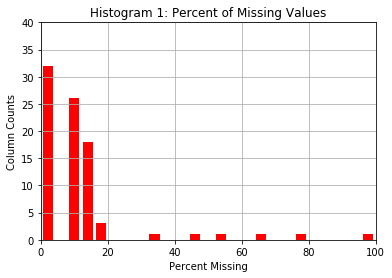

In [17]:
# Build a histogram with the series of percent missing values
plt.hist(feat_info['pct_missing'], bins=25, facecolor='r', rwidth=0.75)
plt.xlabel('Percent Missing')
plt.ylabel('Column Counts')
plt.title('Histogram 1: Percent of Missing Values')
plt.axis([0, 100, 0, 40])
plt.grid(True)
plt.show()

In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In [19]:
# Identify outlier columns
bound = 20
outliers = feat_info.loc[feat_info['pct_missing'] > bound, 'attribute']
print('Features with more than {}% missing values:\n'.format(bound), outliers)

Features with more than 20% missing values:
 0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: attribute, dtype: object


In [20]:
# Checks that `azdias` contains the outliers columns 
drop_ = [col for col in outliers if col in azdias.columns]
# Drop columns
azdias.drop(labels=drop_, axis=1, inplace=True)

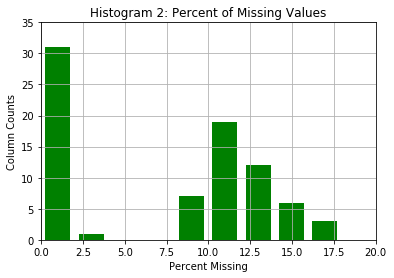

In [21]:
# Build a second histogram of the series of percent missing values 
# — now with the remaining 79 features.
plt.hist(feat_info['pct_missing'], bins=50, facecolor='g', rwidth=0.75)
plt.xlabel('Percent Missing')
plt.ylabel('Column Counts')
plt.title('Histogram 2: Percent of Missing Values')
plt.axis([0, 20, 0, 35])
plt.grid(True)
plt.show()

Below, I investigate some patterns in the amount of missing data in the remaining 79 features.

In [22]:
# Identify 32 features with less than 5% missing values
missing_0_5 = feat_info.loc[feat_info['pct_missing'] < 5, 'attribute']
print(len(missing_0_5), 
      'features with less than 5% missing values:\n\n', 
      missing_0_5)

32 features with less than 5% missing values:

 1      ALTERSKATEGORIE_GROB
2                 ANREDE_KZ
3             CJT_GESAMTTYP
4         FINANZ_MINIMALIST
5             FINANZ_SPARER
6          FINANZ_VORSORGER
7            FINANZ_ANLEGER
8     FINANZ_UNAUFFAELLIGER
9          FINANZ_HAUSBAUER
10                FINANZTYP
12          GFK_URLAUBERTYP
13         GREEN_AVANTGARDE
19           LP_STATUS_FEIN
20           LP_STATUS_GROB
23           RETOURTYP_BK_S
24                SEMIO_SOZ
25                SEMIO_FAM
26                SEMIO_REL
27                SEMIO_MAT
28               SEMIO_VERT
29               SEMIO_LUST
30                SEMIO_ERL
31               SEMIO_KULT
32                SEMIO_RAT
33               SEMIO_KRIT
34                SEMIO_DOM
35               SEMIO_KAEM
36            SEMIO_PFLICHT
37              SEMIO_TRADV
42                 ZABEOTYP
46       HH_EINKOMMEN_SCORE
72        ONLINE_AFFINITAET
Name: attribute, dtype: object


In [23]:
# Identify 47 features with 5%-20% missing values
index_ = (feat_info['pct_missing'] > 5) & (feat_info['pct_missing'] < 20)
missing_5_20 = feat_info.loc[index_, 'attribute']
print(len(missing_5_20), 
      'features with less than 5%-20% missing values:\n\n', 
      missing_5_20)

47 features with less than 5%-20% missing values:

 14               HEALTH_TYP
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
17          LP_FAMILIE_FEIN
18          LP_FAMILIE_GROB
21         NATIONALITAET_KZ
22    PRAEGENDE_JUGENDJAHRE
38              SHOPPER_TYP
39                  SOHO_KZ
41                 VERS_TYP
44             ANZ_PERSONEN
45                ANZ_TITEL
48           W_KEIT_KIND_HH
49           WOHNDAUER_2008
50      ANZ_HAUSHALTE_AKTIV
51             ANZ_HH_TITEL
52              GEBAEUDETYP
53              KONSUMNAEHE
54         MIN_GEBAEUDEJAHR
55              OST_WEST_KZ
56                 WOHNLAGE
57          CAMEO_DEUG_2015
58           CAMEO_DEU_2015
59          CAMEO_INTL_2015
60              KBA05_ANTG1
61              KBA05_ANTG2
62              KBA05_ANTG3
63              KBA05_ANTG4
65                KBA05_GBZ
66                 BALLRAUM
67                 EWDICHTE
68               INNENSTADT
69       GEBAEUDETYP_RASTER
70                      

In [24]:
# print the count of attributes grouped by the information_level
print('Features with less than 5% missing values. \nCount per "information_level":\n\n',
      feat_info.loc[missing_0_5.index, 'information_level'].value_counts())

Features with less than 5% missing values. 
Count per "information_level":

 person        30
region_rr1     1
household      1
Name: information_level, dtype: int64


In [25]:
# print the count of attributes grouped by the information_level
print('Features with 5%-20% missing values. \nCount per "information_level":\n\n',
      feat_info.loc[missing_5_20.index, 'information_level'].value_counts())

Features with 5%-20% missing values. 
Count per "information_level":

 person            10
macrocell_plz8     8
building           7
microcell_rr3      5
region_rr1         4
household          4
community          3
postcode           3
microcell_rr4      3
Name: information_level, dtype: int64


In [26]:
# print the count of attributes grouped by the information_level
print('Outliers, more than 20% missing values. \nCount per "information_level":\n\n',
      feat_info.loc[outliers.index, 'information_level'].value_counts())

Outliers, more than 20% missing values. 
Count per "information_level":

 person           3
household        2
microcell_rr3    1
Name: information_level, dtype: int64


#### Discussion 1.1.2: Assess Missing Data in Each Column

I first built a new dataframe of the features in `azdias` which includes their corresponding count of missing values and the percentage of missing values. 

I used this dataframe to create Histogram 1 (red bars) with the series of percent missing values, which shows that there are 6 features/columns that are missing more than 20% of their values. I drop these 6 columns from `azdias`. 

Using the remaining 79 features, I created Histogram 2 (green bars) with the series of percent missing values. This histogram shows that 32 features have less than 5% missing values; with another group of 47 features having 5% - 20% missing values. 

In order to investigate patterns in the amount of missing data in these remaining 79 features, I separated the features into these two groups:
1. attributes with less than 5% missing values
2. attributes with 5% - 20% missing values

Finally I used the `feat_info` dataframe to investigate whether the most relevant characteristic of the attributes, "information_level", is associated with the amount of missing data.

I found that for the 32 attributes with less than 5% missing values, 30 are observed at the person level. In contrast, the 47 attributes with 5% - 20% missing values are more evenly distributed with respect to information level: 10 are person level, 4 are household level, and the remaining 33 are higher levels of aggregation (e.g., building, region, post code).

I went back to do a similar analysis of the outliers — attributes with more than 20% missing values — and found that 3 are observed at the person level, 2 at the household level, and 1 at the microcell level.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
# Count missing values per row
count_missing = azdias.isnull().sum(axis=1)
pct_missing = np.float16(count_missing / azdias.shape[1] * 100)

In [28]:
# Use a counter to get the number of rows that show a given number of missing features
counter = Counter(count_missing)
# Print the counts for the relevant subset of missing features
for i in range(count_missing.min(), count_missing.max()+1):
    if i in counter:
        print('Rows with {} missing features: {:,}'.format(i, counter[i]))

Rows with 0 missing features: 623,209
Rows with 1 missing features: 15,738
Rows with 2 missing features: 27,926
Rows with 3 missing features: 17,629
Rows with 4 missing features: 12,607
Rows with 5 missing features: 22,515
Rows with 6 missing features: 13,771
Rows with 7 missing features: 13,714
Rows with 8 missing features: 24,592
Rows with 9 missing features: 3,042
Rows with 10 missing features: 5,410
Rows with 11 missing features: 1,127
Rows with 12 missing features: 766
Rows with 13 missing features: 3,255
Rows with 14 missing features: 2,243
Rows with 15 missing features: 4,743
Rows with 16 missing features: 2,505
Rows with 17 missing features: 677
Rows with 18 missing features: 428
Rows with 19 missing features: 1,180
Rows with 20 missing features: 349
Rows with 21 missing features: 150
Rows with 22 missing features: 129
Rows with 23 missing features: 132
Rows with 24 missing features: 69
Rows with 25 missing features: 55
Rows with 26 missing features: 59
Rows with 27 missing fea

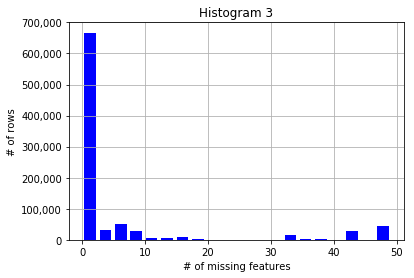

In [29]:
# Build a histogram with the series of missing features per row
ax1 = plt.subplot()
plt.hist(count_missing, bins=20, facecolor='b', rwidth=0.75)
plt.xlabel('# of missing features')
plt.ylabel('# of rows')
plt.title('Histogram 3')
plt.grid(True)
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
plt.show()

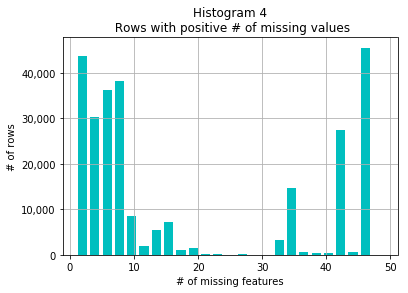

In [30]:
# Build second histogram with the series of missing features per row
# with modified axis in order to zoom into rows with positive # of missing values
ax2 = plt.subplot()
plt.hist(count_missing[count_missing > 0], bins=25, facecolor='c', rwidth=0.75)
plt.xlabel('# of missing features')
plt.ylabel('# of rows')
plt.title('Histogram 4\n Rows with positive # of missing values')
plt.grid(True)
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax2.get_yticks().tolist()])
plt.show()

In [31]:
# Get indices for rows with less than 9 missing features
index_1 = (count_missing < 9)
# Get indices for rows with >= 9 and <= 32 missing features
index_2 = (count_missing >= 9) & (count_missing <= 32)
# Get indices for rows with more than 32 missing features
index_3 = (count_missing > 32)

# Print dimensions of subsets
print('Subset 1 : # of rows with missing features < 9:\n  {:,}'.format(
    sum(index_1)))
print('Subset 2 : # of rows with 9 <= missing features <= 32:\n  {:,}'.format(
    sum(index_2)))
print('Subset 3 : # of rows with missing features > 32:\n  {:,}'.format(
    sum(index_3)))

Subset 1 : # of rows with missing features < 9:
  771,701
Subset 2 : # of rows with 9 <= missing features <= 32:
  26,575
Subset 3 : # of rows with missing features > 32:
  92,945


In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [33]:
# Helper function
def cat_distribution(df_1, df_2, df_3, column_name):
    """
    Plot the distribution of values for a single feature 
    contrasting said distribution between the subsets created above
    
    INPUT: 
        df_1
        df_2
        df_3
        column_name - column/feature name
    OUTPUT: 
        None - plots the two distributions side by side
    """
    ax1 = plt.subplot(1, 3, 1)
    sns.countplot(x=column_name, data=df_1)
    plt.xlabel('subset 1')
    plt.ylabel('# of rows')
    ax1.set_yticklabels([str(int(x))[0:3] + 'k' for x in ax1.get_yticks().tolist()])
    ax1.set_xticklabels([str(int(x)) for x in ax1.get_xticks().tolist()])

    ax2 = plt.subplot(1, 3, 2)
    sns.countplot(x=column_name, data=df_2)
    plt.xlabel('subset 2')
    plt.ylabel('# of rows')
    ax2.set_xticklabels([str(int(x)) for x in ax2.get_xticks().tolist()])
    
    ax3 = plt.subplot(1, 3, 3)
    sns.countplot(x=column_name, data=df_3)
    plt.xlabel('subset 3')
    plt.ylabel('# of rows')
    ax3.set_xticklabels([str(int(x)) for x in ax3.get_xticks().tolist()])

    plt.suptitle(column_name)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [34]:
# Identify the columns with no missing data
count_per_col = azdias.isnull().sum(axis=0)
clean_cols = count_per_col[count_per_col == 0].index
print('Columns with no missing data: ', len(clean_cols))
print('\n',clean_cols)

Columns with no missing data:  24

 Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'ZABEOTYP'],
      dtype='object')


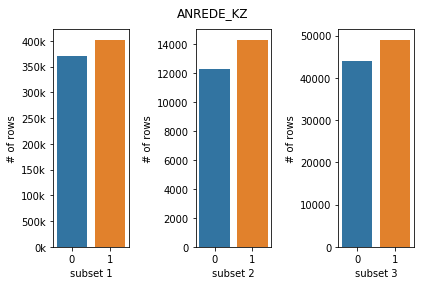

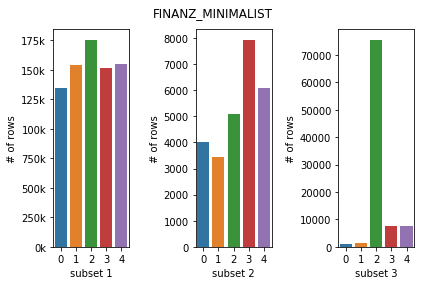

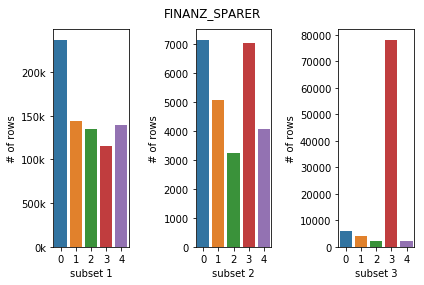

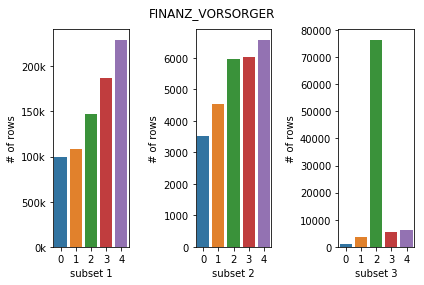

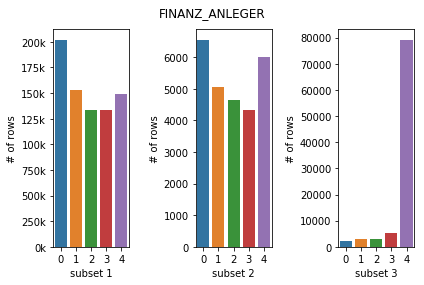

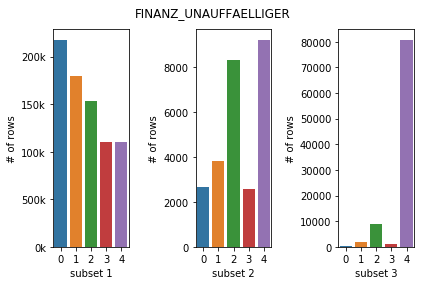

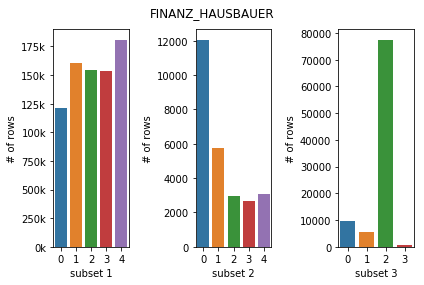

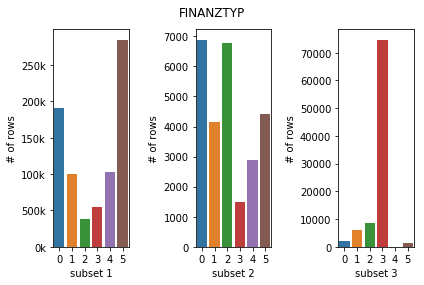

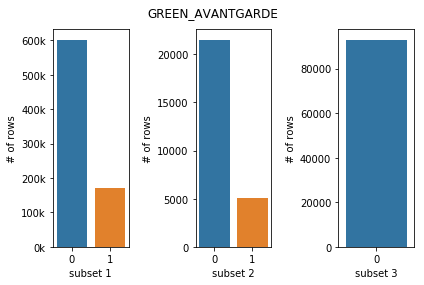

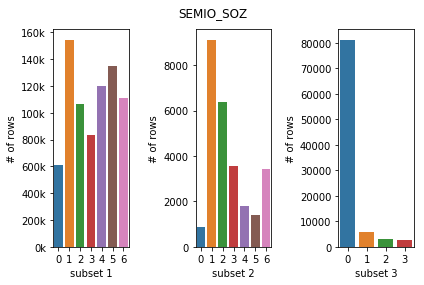

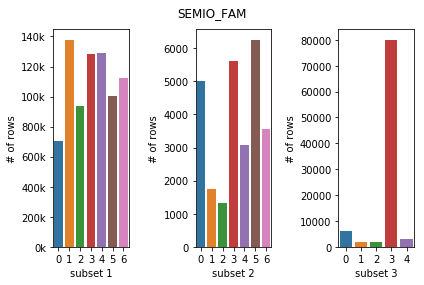

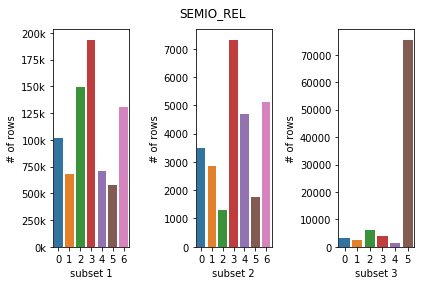

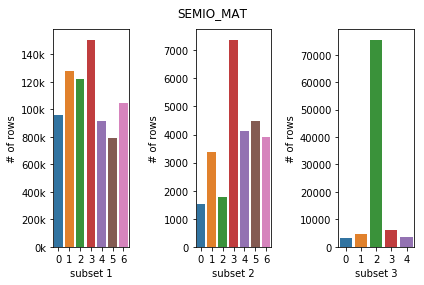

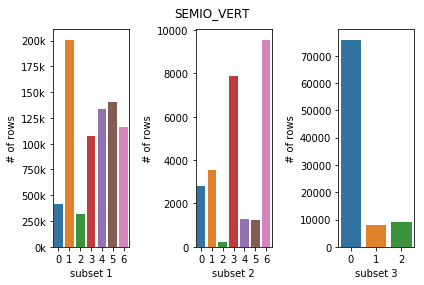

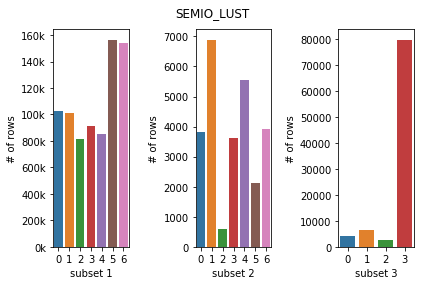

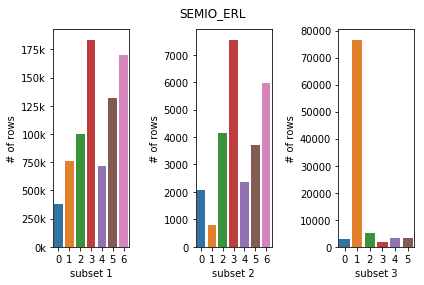

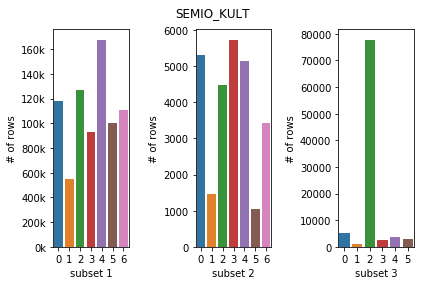

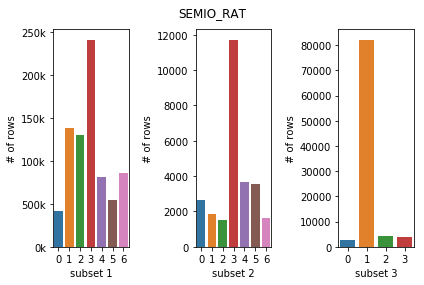

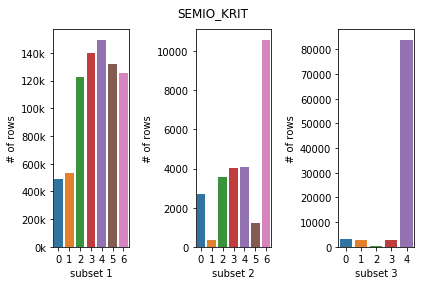

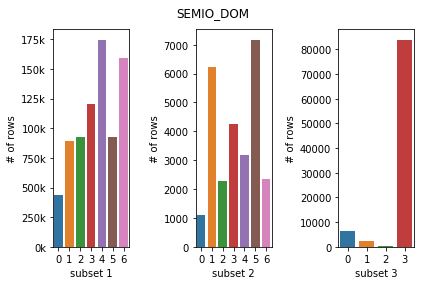

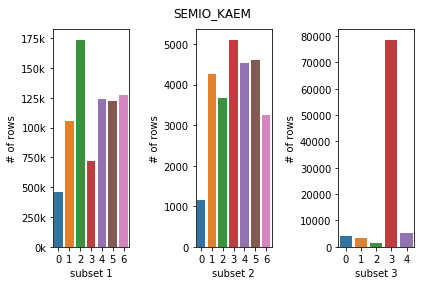

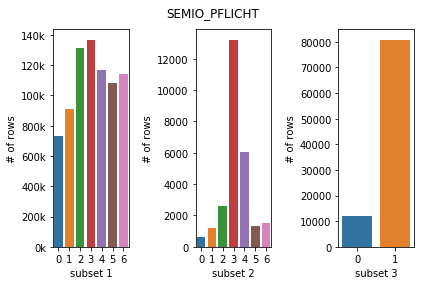

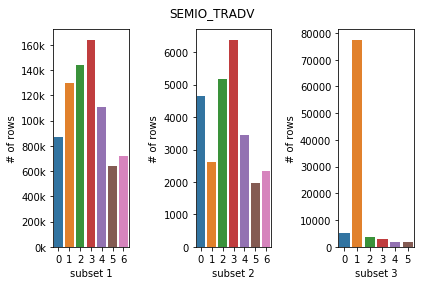

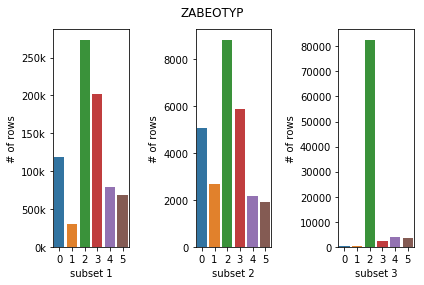

In [35]:
# Plot and contrast the distribution of categories for all columns with no missing data
df_1, df_2, df_3 = azdias[index_1], azdias[index_2], azdias[index_3]
for column_name in clean_cols:
    cat_distribution(df_1, df_2, df_3, column_name)

In [36]:
# As directed, I will continue the analysis using just the subset 
# of the data with few or no missing values - i.e. missing features < 9
azdias_1 = azdias[index_1]

#### Discussion 1.1.3: Assess Missing Data in Each Row

Histograms 3 and 4 show the distribution of missing values per row in the dataset. Histogram 4 is a zoomed-in version of Histogram 3 that excludes rows with no missing values. 

Histogram 4 shows that most rows with any missing values have at most 8 missing features. The count of rows declines almost consistently from 9 to 32 missing features. We see significant spikes in the count of rows starting again at 33 missing features. 

Based on this (and my reviewer’s feedback) I separate the dataset in 3 subsets:
- Subset 1 : rows with `missing features < 9` : 771,701
-  Subset 2 : rows with `9 <= missing features <= 32` : 26,575
-  Subset 3 : rows with `missing features > 32` : 92,945

In order to investigate if the distribution of data values on columns that are not missing data are similar between these subsets,  I identified the 24 columns with no missing values and used a helper function to plot  the distribution of values in each of these 24 columns. That is, contrasting each distribution side-by-side between the 3 subsets.

The plots show that for most columns with no missing values the distributions of values are similar between *subset 1* and *subset 2* . However, the plots also show that the distributions of values in *subset 3* do look qualitatively different than the other two subsets. 

This visual comparisons suggests that keeping the rows in subset 1 (missing features < 9) and dropping the rows in subset 2 should not present a major issue for our analysis of clusters or segments. On the other hand, subset 3 (missing features > 32) seems to be different from the other two subsets in a systematic way, which would imply that dropping those observations introduces bias in the analysis. 

That said, I follow the instructions above and continue the analysis for now using just the subset of data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [37]:
# How many features are there of each data type?

In [38]:
# Create counter of number of features/columns per type of measurement
feat_types = Counter(feat_info['type'])
print(feat_types)

Counter({'ordinal': 49, 'categorical': 21, 'numeric': 7, 'mixed': 7, 'interval': 1})


In [39]:
# Create dictionary to map feature types to feature/column names
feat_types = dict()
for f_type in set(feat_info['type']):
    feat_types[f_type] = feat_info['attribute'][feat_info['type'] == f_type].tolist()

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [41]:
# Create dictionary to map categoricals to their set of possible/unique values
categoricals_values = dict()

# Populate dictionary for all categoricals
for feature in feat_types['categorical']:
    if feature in azdias_1:
        categoricals_values[feature] = azdias_1[feature].dropna().unique().tolist()
    else:
        continue

# Print quantity of categoricals in original data
print('Number of categorical variables in working dataset: {}'.format(
    len(categoricals_values)))

Number of categorical variables in working dataset: 18


In [42]:
# Create lists to split names of binary and multilevel categoricals
feat_types['binary'] = list()
feat_types['multilevel'] = list()

# Populate lists based on categoricals_values dictionary
for categorical, set_values in categoricals_values.items():
    if len(set_values) == 2:
        feat_types['binary'].append(categorical)
    elif len(set_values) > 2:
        feat_types['multilevel'].append(categorical)
        
# Print results
print('Number of binary categoricals in working dataset:       {}'.format(
    len(feat_types['binary'])))
print('Number of multi-level categoricals in working dataset: {}'.format(
     len(feat_types['multilevel'])))

Number of binary categoricals in working dataset:       5
Number of multi-level categoricals in working dataset: 13


In [43]:
# Investigate the type of values for each binary categorical
for feature in feat_types['binary']:
    print('Values in feature {}: \n {} \n'.format(
        feature, categoricals_values[feature]))

Values in feature ANREDE_KZ: 
 [2.0, 1.0] 

Values in feature GREEN_AVANTGARDE: 
 [0, 1] 

Values in feature SOHO_KZ: 
 [1.0, 0.0] 

Values in feature VERS_TYP: 
 [2.0, 1.0] 

Values in feature OST_WEST_KZ: 
 ['W', 'O'] 



In [44]:
# OST_WEST_KZ requires re-encoding since it takes non-numeric values
original_feat = 'OST_WEST_KZ'
eng_feat = 'OST_WEST_KZ_num'

# Re-encode OST_WEST_KZ: 1 for 'W', 0 for 'O'
azdias_1[eng_feat] = azdias_1[original_feat].apply(lambda x: 1 if x == 'W' else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
# Helper function
def add_to_reencoded(reencoded_feat, original_feat, eng_feat_list):
    """
    Checks if the names are already in dict reencoded_feat and returns updated version
    
    INPUT: 
        reencoded_feat - dict mapping original feature name to list of new feature names
        original_feat - original feature name
        eng_feat_list - list of new feature names
    OUTPUT: 
        reencoded_feat - with added feature names, if appropriate 
    """
    if not isinstance(eng_feat_list, list):
        print('Error: The new or engineered features should be in a list.')
        return None
    if original_feat not in reencoded_feat:
        reencoded_feat[original_feat] = eng_feat_list
        return reencoded_feat
    else:
        print('Warning: "{}" is already recorded.'.format(original_feat))
        for eng_feat in eng_feat_list:
            if eng_feat not in reencoded_feat[original_feat]:
                print('"{}" added to its re-encoded features.'.format(eng_feat))
                reencoded_feat[original_feat].append(eng_feat)
            else:
                continue
        return reencoded_feat

In [46]:
# Create dictionary to track column/feature engineering
# i.e. mapping original feature name to list of new feature names
reencoded_feat = dict()

In [47]:
# Keep track of outlier columns from previous section - i.e. > 40% missing values
# Add to reencoded_feat
for feature in outliers:
    add_to_reencoded(reencoded_feat, feature, [])

In [48]:
# Keep track of re-encoded binary categorical
# Add to reencoded_feat
add_to_reencoded(reencoded_feat, original_feat, [eng_feat])

{'AGER_TYP': [],
 'GEBURTSJAHR': [],
 'TITEL_KZ': [],
 'ALTER_HH': [],
 'KK_KUNDENTYP': [],
 'KBA05_BAUMAX': [],
 'OST_WEST_KZ': ['OST_WEST_KZ_num']}

#### Discussion 1.2.1: Re-Encode Categorical Features

The feat_info table indicates that the original data includes 5 general types of measurements: 
- ordinal - 49 columns
- categorical - 21 columns
- numeric - 7 columns
- mixed - 7 columns
- interval - 1 column.

Of the original 21 categoricals, 3 were dropped in the previous section due to large proportions of missing values. In Step 1.2.1, I work with the set of remaining 18 categoricals: 
- 13 multi-level
- 5 binary. 

I follow the recommendation for simplicity and drop the 13 multi-level categoricals. I also re-encode the binary type that takes on string values: 'W'==1 and 'O'==0.

Finally, I use a dictionary to keep track of the re-encoding of features, mapping the original column names to the re-encoded or new column names. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [49]:
# Print quantity of mixed-type variables in original data
print('Number of mixed-type variables in original dataset: {}'.format(
    len(feat_types['mixed'])))

Number of mixed-type variables in original dataset: 7


In [50]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
original_feat = 'PRAEGENDE_JUGENDJAHRE'

In [51]:
# Print set of unique values in "PRAEGENDE_JUGENDJAHRE"
feature_values = azdias_1[original_feat].dropna().unique().tolist()
print('Values in feature {}: \n {} \n'.format(
    original_feat, feature_values))
print('which are of types: \n {}'.format(
    set([type(x) for x in feature_values])))

Values in feature PRAEGENDE_JUGENDJAHRE: 
 [14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 5.0, 9.0, 6.0, 4.0, 2.0, 1.0, 12.0, 13.0, 7.0] 

which are of types: 
 {<class 'float'>}


In [52]:
# Helper function
def decade(value):
    """
    Transforms values from floats to interval objects
    to re-encode the 'decade' dimension of PRAEGENDE_JUGENDJAHRE
    
    INPUT: 
        value - feature value (float)
    OUTPUT: 
        re-encoded interval object 
    """
    if value in set([1.0, 2.0]):
        return 0
    elif value in set([3.0, 4.0]):
        return 1
    elif value in set([5.0, 6.0, 7.0]):
        return 2
    elif value in set([8.0, 9.0]):
        return 3
    elif value in set([10.0, 11.0, 12.0, 13.0]):
        return 4
    elif value in set([14.0, 15.0]):
        return 5
    else:
        return value

# Test function    
print(decade(10.0))

4


In [53]:
# Re-encode "PRAEGENDE_JUGENDJAHRE" - "decade" dimension
eng_feat_1 = 'PRAEGENDE_JUGENDJAHRE_decade'
azdias_1[eng_feat_1] = azdias_1[original_feat].apply(decade)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
# Helper function
def movement(value):
    """
    Transforms values from floats to binary objects
    to re-encode the 'movement' dimension of PRAEGENDE_JUGENDJAHRE
    
    INPUT: 
        value - feature value (float)
    OUTPUT: 
        re-encoded binary object 
    """
    # Create the two sets of values that separate the "movement" dimension
    mainstream = set([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    avantgarde = set([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])

    if value in avantgarde:
        return 1
    elif value in mainstream:
        return 0
    else:
        return value

In [55]:
# Re-encode "PRAEGENDE_JUGENDJAHRE" - "movement" dimension
eng_feat_2 = 'PRAEGENDE_JUGENDJAHRE_movement'
azdias_1[eng_feat_2] = azdias_1[original_feat].apply(movement)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
# Keep track of re-encoded mixed-type variables
# Add to reencoded_feat
add_to_reencoded(reencoded_feat, original_feat, [eng_feat_1, eng_feat_2]);

In [57]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
original_feat = 'CAMEO_INTL_2015'

In [58]:
# Print set of unique values in "CAMEO_INTL_2015"
feature_values = azdias_1[original_feat].dropna().unique().tolist()
print('Values in feature {}: \n {} \n'.format(
    original_feat, feature_values))
print('which are of types: \n {}'.format(
    set([type(x) for x in feature_values])))

Values in feature CAMEO_INTL_2015: 
 ['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'] 

which are of types: 
 {<class 'str'>}


In [59]:
# Re-encode "CAMEO_INTL_2015" - "wealth" dimension
eng_feat_1 = 'CAMEO_INTL_2015_wealth'
azdias_1[eng_feat_1] = azdias_1[original_feat].apply(
                       lambda x: int(x[0]) if isinstance(x, str) else x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [60]:
# Re-encode "CAMEO_INTL_2015" - "stage" dimension
eng_feat_2 = 'CAMEO_INTL_2015_stage'
azdias_1[eng_feat_2] = azdias_1[original_feat].apply(
                       lambda x: int(x[1]) if isinstance(x, str) else x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [61]:
add_to_reencoded(reencoded_feat, original_feat, [eng_feat_1, eng_feat_2]);

In [108]:
# Investigate "WOHNLAGE" and engineer two new variables.
original_feat = 'WOHNLAGE'

In [109]:
# Print set of unique values in "WOHNLAGE"
feature_values = azdias_1[original_feat].dropna().unique().tolist()
print('Values in feature {}: \n {} \n'.format(
    original_feat, feature_values))
print('which are of types: \n {}'.format(
    set([type(x) for x in feature_values])))

Values in feature WOHNLAGE: 
 [4.0, 2.0, 7.0, 3.0, 5.0, 1.0, 8.0, 0.0] 

which are of types: 
 {<class 'float'>}


In [110]:
# Helper function
def neighborhood(value):
    """
    Re-encodes the 'neighborhood quality' dimension of WOHNLAGE
    
    INPUT: 
        value - "WOHNLAGE" attribute
    OUTPUT: 
        re-encoded neighborhood quality
    """
    if np.isnan(value): 
        return value
    if value in [1., 2., 3., 4., 5.]: 
        return value
    else: 
        return 0

# Test function    
print(neighborhood(8.0))

0


In [111]:
# Re-encode "WOHNLAGE" - "neighborhood quality" dimension
eng_feat_1 = 'WOHNLAGE_neighborhood'
azdias_1[eng_feat_1] = azdias_1[original_feat].apply(neighborhood)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
# Helper function
def rural(value):
    """
    Re-encodes the 'rural flag' dimension of WOHNLAGE
    
    INPUT: 
        value - "WOHNLAGE" attribute
    OUTPUT: 
        re-encoded rural flag
    """
    if np.isnan(value): 
        return value
    elif value == 7: 
        return 1
    elif value == 8: 
        return 2
    else: 
        return 0

# Test function    
print(rural(8.0))

2


In [113]:
# Re-encode "WOHNLAGE" - "rural flag" dimension
eng_feat_2 = 'WOHNLAGE_rural'
azdias_1[eng_feat_2] = azdias_1[original_feat].apply(rural)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
add_to_reencoded(reencoded_feat, original_feat, [eng_feat_1, eng_feat_2])

{'AGER_TYP': [],
 'GEBURTSJAHR': [],
 'TITEL_KZ': [],
 'ALTER_HH': [],
 'KK_KUNDENTYP': [],
 'KBA05_BAUMAX': [],
 'OST_WEST_KZ': ['OST_WEST_KZ_num'],
 'PRAEGENDE_JUGENDJAHRE': ['PRAEGENDE_JUGENDJAHRE_decade',
  'PRAEGENDE_JUGENDJAHRE_movement'],
 'CAMEO_INTL_2015': ['CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_stage'],
 'WOHNLAGE': ['WOHNLAGE_neighborhood', 'WOHNLAGE_rural']}

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the handful of features that are marked as *mixed* in the feature summary, I also follow the recommendation for simplicity; that is, I drop most of them and only re-encode and keep three in the analysis: "PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", and "WOHNLAGE".

- "PRAEGENDE_JUGENDJAHRE" is re-encoded into "PRAEGENDE_JUGENDJAHRE_decade" (interval) and "PRAEGENDE_JUGENDJAHRE_movement" (binary).

- "CAMEO_INTL_2015" is re-encoded into two multi-level categoricals: "CAMEO_INTL_2015_wealth" and "CAMEO_INTL_2015_stage".

- "WOHNLAGE" is re-encoded into two multi-level categoricals: "WOHNLAGE_neighborhood" and "WOHNLAGE_rural". 

**Note**: I keep "WOHNLAGE" based on a recommendation by my project reviewer.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [114]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [115]:
# Create empty list to keep track of feature selection 
feature_selection = list()

# Append all numeric, interval, and ordinal type columns
# from the original dataset
for f_type in ['numeric', 'interval', 'ordinal']:
    for f_name in feat_types[f_type]:
        feature_selection.append(f_name)

# Print feature selection
print('Number of features selected so far: {}'.format(
    len(feature_selection)))

Number of features selected so far: 57


In [116]:
# Append binary type columns 
for f_name in feat_types['binary']:
    feature_selection.append(f_name)

# Print feature selection
print('Number of selected binary categoricals: {}'.format(
    len(feat_types['binary'])))
print('Number of features selected so far:    {}'.format(
    len(feature_selection)))

Number of selected binary categoricals: 5
Number of features selected so far:    62


In [117]:
# Append new re-encoded columns 
count = 0
for list_new_f in reencoded_feat.values():
    for f_name in list_new_f:
        feature_selection.append(f_name)
        count += 1

# Print feature selection
print('Number of newly encoded variables:   {}'.format(count))
print('Number of features selected so far: {}'.format(
    len(feature_selection)))

Number of newly encoded variables:   7
Number of features selected so far: 69


In [118]:
# Drop original features that were re-encoded 
# or removed due to missing data
feature_selection = [feature for feature in feature_selection 
                     if feature not in reencoded_feat.keys()]

# Print feature selection
print('Number of features selected so far: {}'.format(
    len(feature_selection)))

Number of features selected so far: 66


In [120]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [121]:
# Make list of features to drop from working dataset
drop_list = [col for col in azdias_1.columns.tolist() if col not in feature_selection]
# Drop columns from azdias_1 to get the clean, engineered dataset
azdias_eng = azdias_1.drop(inplace=False, axis=1, labels=drop_list)

In [122]:
# Print dimensions of working dataset
print('Shape of dataset after feature selection: {:,} x {}'.format(
    azdias_eng.shape[0], azdias_eng.shape[1]))

Shape of dataset after feature selection: 771,701 x 66


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [123]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for feature in df:
        # retrieve list of codes for missing values from feat_info
        nan_codes = feat_info.loc[feat_info['attribute'] == feature, 'missing_codes'].iloc[0]
        # loop through list of codes
        for code in nan_codes:
            if code == '': continue
            # transform code from string to integer 
            if code.isnumeric() or code.lstrip('-').isnumeric():
                code = int(code)
            # replace coded values in df dataframe with numpy NaN
            index = df[feature] == code
            df.loc[index, feature] = np.nan

    # remove selected columns and rows, ...
    
    ## drop columns with more than 20% missing values
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ',
                 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(labels=drop_cols, axis=1, inplace=True)  
    
    ## Count missing values per row 
    count_missing = df.isnull().sum(axis=1)
    # Get indices for rows with less than 9 missing features
    bool_idx = (count_missing < 9)
    ## Drop these rows to get a 'clean' DataFrame
    df = df[bool_idx]
    
    # select, re-encode, and engineer column values.

    ## Re-encode OST_WEST_KZ: 1 for 'W', 0 for 'O'
    original_feat = 'OST_WEST_KZ'
    eng_feat = 'OST_WEST_KZ_num'
    df[eng_feat] = df[original_feat].apply(lambda x: 1 if x == 'W' else 0)
    ## Re-encode "PRAEGENDE_JUGENDJAHRE" - "decade" dimension
    original_feat = 'PRAEGENDE_JUGENDJAHRE'
    eng_feat_1 = 'PRAEGENDE_JUGENDJAHRE_decade'
    df[eng_feat_1] = df[original_feat].apply(decade)
    ## Re-encode "PRAEGENDE_JUGENDJAHRE" - "movement" dimension
    eng_feat_2 = 'PRAEGENDE_JUGENDJAHRE_movement'
    df[eng_feat_2] = df[original_feat].apply(movement)
    ## Re-encode "CAMEO_INTL_2015"
    original_feat = 'CAMEO_INTL_2015'
    eng_feat_1 = 'CAMEO_INTL_2015_wealth'
    df[eng_feat_1] = df[original_feat].apply(
                       lambda x: int(x[0]) if isinstance(x, str) else x)
    eng_feat_2 = 'CAMEO_INTL_2015_stage'
    df[eng_feat_2] = df[original_feat].apply(
                       lambda x: int(x[1]) if isinstance(x, str) else x)
    ## Re-encode "WOHNLAGE"
    original_feat = 'WOHNLAGE'
    eng_feat_1 = 'WOHNLAGE_neighborhood'
    df[eng_feat_1] = df[original_feat].apply(neighborhood)
    eng_feat_2 = 'WOHNLAGE_rural'
    df[eng_feat_2] = df[original_feat].apply(rural)

    # Return the cleaned dataframe.

    ## Make list of features to drop from working dataset
    drop_list = [col for col in df.columns.tolist() 
                    if col not in feature_selection]
    ## Drop columns from df, in place
    df.drop(inplace=True, axis=1, labels=drop_list)
    return df 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [124]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [125]:
# Apply imputation to full dataset
imputer = Imputer(missing_values="NaN", strategy="median", axis=0)
azdias_imp = imputer.fit_transform(azdias_eng)

In [126]:
# Temporarily remove missing values
azdias_temp = azdias_eng.dropna(axis='index', inplace=False)
# Compute the scaling parameters
scaler = StandardScaler().fit(azdias_temp)

In [127]:
# Apply feature scaling to the general population demographics data.
azdias_scaled = scaler.transform(azdias_imp)

### Discussion 2.1: Apply Feature Scaling

I decided to temporarily remove missing values in order to compute the scaling parameters. 

I create a new dataset by fitting the Imputer (using the median) and transforming the "azdian" dataset. Separately, I fit the scaler to the temporary dataset with removed missing values. I then apply this scaler to the dataset with imputed values. 

My intuition says that this option makes the missing values less influential in the distribution of features, since the corresponding imputed values are not used to estimate the parameters needed to perform feature scaling. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [130]:
# Apply PCA to the data.

## Fit and transform using pca
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)
print('Shape of azdias_pca: {:,} x {}'.format(
        azdias_pca.shape[0], azdias_pca.shape[1]))

Shape of azdias_pca: 771,701 x 66


In [131]:
# Investigate the variance accounted for by each principal component.

In [132]:
# Helper function to plot the variance explained by PCA
def scree_plot(pca, num_components='all'):
    """
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result PCA fit in scikit learn
            
    OUTPUT: None
    """
    
    if num_components == 'all':
        num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)[0:num_components]
    vals = pca.explained_variance_ratio_[0:num_components]
 
    plt.figure(figsize=(10, 6))
    ax1 = plt.subplot(111)
    ax1.bar(ind, vals, color='c')
    for i in range(num_components):
        ax1.annotate(r"%s" % (str(vals[i]*100)[:4]), (ind[i]+0.2, vals[i]), 
                    va="bottom", ha="center", fontsize=8)
    
    ax2 = ax1.twinx()
    cumvals = np.cumsum(vals)
    ax2.plot(ind, cumvals, color='r')
    
    ax1.xaxis.set_tick_params(width=0)
    ax1.yaxis.set_tick_params(width=2, length=12, color='c')
    ax2.yaxis.set_tick_params(width=2, length=12, color='r')
 
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Ratio of Variance Explained (%)")
    ax2.set_ylabel("Cumulative Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

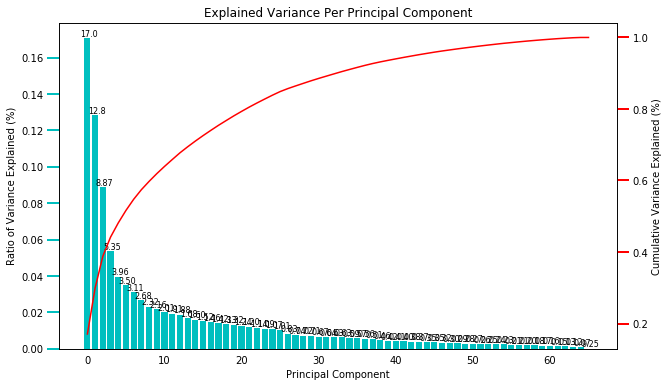

In [133]:
# Scree plot for full set of principal components
scree_plot(pca, num_components='all')

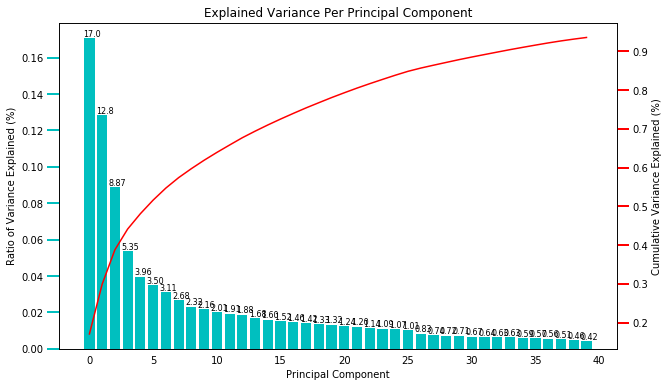

In [136]:
# Scree plot for the first 40 principal components
scree_plot(pca, num_components=40)

In [78]:
# Re-apply PCA to the data while selecting for number of components to retain.

In [137]:
## Fit and transform using pca
pca_40 = PCA(n_components=40)
pca_40 = pca_40.fit(azdias_scaled)
azdias_pca_40 = pca_40.transform(azdias_scaled)
print('Shape of azdias_pca_40: {:,} x {}'.format(
        azdias_pca_40.shape[0], azdias_pca_40.shape[1]))

Shape of azdias_pca_40: 771,701 x 40


### Discussion 2.2: Perform Dimensionality Reduction

I use and modify the code provided in the `helper_functions.py` file to create the scree plot above. The left axis corresponds to the bars for ratio of variance explained by component; the right axis corresponds to the cumulative variance (red line). 

The plot shows that the "elbow" of the variance-explained curve is not clearly identified; in other words, the marginal variance-explained declines gradually, with no significant inflection point that would provide one clear choice for number of PCA components (if one were using the marginal variance-explained criterion).

I'm following my project reviewer's recommendation by choosing 40 components, which retains more than 90% of the variance; as seen in the scree plot.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [138]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [140]:
def pca_results(full_dataset, pca, nth_component=1):
    """
    Map weights for the principal component to corresponding feature names
    and then print the linked values, sorted by weight.
    
    INPUT:  full_dataset - azdias dataset
            pca - the result PCA fit in scikit learn
            nth_component - principal component to investigate
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # nth_component indexing
    suffix = {1:'st', 2:'nd', 3:'rd'}
    component_index = ['{}{}'.format(i, suffix.get(i, 'th'))
                       for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), 
                              columns = full_dataset.keys())
    components.index = component_index
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(
                                            len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), 
                                   columns = ['Explained Variance'])  
    variance_ratios.index = component_index
    
    label = '{}{}'.format(nth_component, suffix.get(nth_component, 'th'))
    weights = components.loc[label,]
    sorted_weights = weights.loc[
        weights.abs().sort_values(ascending=False).index]
    
    first_n_feat = 30
    
    print('— {} PRINCIPAL COMPONENT —'.format(label))
    print('\nExplained variance: {}'.format(variance_ratios.loc[label][0]))
    print('\n{} most prominent features by weight:'.format(first_n_feat))
    print(sorted_weights.iloc[0:first_n_feat])
                  
    return None

In [141]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_eng, pca_40, nth_component=1)

— 1st PRINCIPAL COMPONENT —

Explained variance: 0.1707

30 most prominent features by weight:
MOBI_REGIO                       -0.2352
PLZ8_ANTG3                        0.2275
PLZ8_ANTG1                       -0.2215
PLZ8_ANTG4                        0.2175
KBA05_GBZ                        -0.2116
KBA05_ANTG1                      -0.2115
ORTSGR_KLS9                       0.2105
EWDICHTE                          0.2087
CAMEO_INTL_2015_wealth            0.2042
FINANZ_MINIMALIST                -0.2028
HH_EINKOMMEN_SCORE                0.2017
WOHNLAGE_neighborhood             0.1810
WOHNLAGE_rural                   -0.1731
KONSUMNAEHE                      -0.1730
INNENSTADT                       -0.1698
FINANZ_HAUSBAUER                  0.1692
PLZ8_GBZ                         -0.1644
PLZ8_ANTG2                        0.1567
KBA05_ANTG4                       0.1523
ARBEIT                            0.1499
RELAT_AB                          0.1421
ANZ_HAUSHALTE_AKTIV               0.1377
KBA

In [142]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_eng, pca_40, nth_component=2)

— 2nd PRINCIPAL COMPONENT —

Explained variance: 0.1285

30 most prominent features by weight:
ALTERSKATEGORIE_GROB            0.2705
SEMIO_REL                      -0.2697
PRAEGENDE_JUGENDJAHRE_decade   -0.2610
FINANZ_SPARER                  -0.2568
FINANZ_VORSORGER                0.2450
FINANZ_UNAUFFAELLIGER          -0.2391
SEMIO_TRADV                    -0.2351
SEMIO_ERL                       0.2348
SEMIO_PFLICHT                  -0.2345
FINANZ_ANLEGER                 -0.2204
SEMIO_KULT                     -0.2196
SEMIO_LUST                      0.1892
SEMIO_FAM                      -0.1861
SEMIO_RAT                      -0.1792
RETOURTYP_BK_S                  0.1674
SEMIO_MAT                      -0.1655
ONLINE_AFFINITAET              -0.1578
W_KEIT_KIND_HH                  0.1117
SEMIO_KRIT                      0.1094
SEMIO_SOZ                      -0.1024
FINANZ_MINIMALIST               0.0996
SEMIO_KAEM                      0.0988
FINANZ_HAUSBAUER                0.0948
MIN_GEBA

In [144]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_eng, pca_40, nth_component=3)

— 3rd PRINCIPAL COMPONENT —

Explained variance: 0.0888

30 most prominent features by weight:
ANREDE_KZ                        -0.3723
SEMIO_VERT                        0.3533
SEMIO_KAEM                       -0.3317
SEMIO_DOM                        -0.3060
SEMIO_KRIT                       -0.2762
SEMIO_SOZ                         0.2654
SEMIO_FAM                         0.2520
SEMIO_KULT                        0.2371
SEMIO_RAT                        -0.2089
FINANZ_ANLEGER                   -0.1929
SEMIO_ERL                        -0.1806
FINANZ_MINIMALIST                 0.1661
RETOURTYP_BK_S                    0.1066
FINANZ_SPARER                    -0.1056
PRAEGENDE_JUGENDJAHRE_decade     -0.1013
FINANZ_VORSORGER                  0.0974
FINANZ_UNAUFFAELLIGER            -0.0954
W_KEIT_KIND_HH                    0.0836
SEMIO_REL                         0.0773
ALTERSKATEGORIE_GROB              0.0733
SEMIO_PFLICHT                    -0.0723
SEMIO_TRADV                      -0.0721
SEM

### Discussion 2.3: Interpret Principal Components

— 1st PRINCIPAL COMPONENT —

The first principal component includes large weights for correlated regional features that are associated with type of dwelling and density of population. For instance, `PLZ8_ANTG1` (number of 1-2 family houses in the PLZ8 region) and `PLZ8_ANTG3` (number of 6-10 family houses in the PLZ8 region) have similar weights with opposing directions, which indicate that whether an individual lives in a region with mostly single-/dual-family housing versus multi-family housing captures a large portion of the variance in our data. Other features like `KBA05_GBZ` (number of buildings in the microcell) and `EWDICHTE` (density of households) are similarly important regional features in the first principal component. 

But the first principal component also involves contributions from features at the person and household levels, which are directly associated with financial status; `FINANZ_MINIMALIST` (low financial interest) and `FINANZ_HAUSBAUER` (home ownership) have similar weights in opposing directions. `HH_EINKOMMEN_SCORE` (estimated household income) and `CAMEO_INTL_2015_wealth` (average household wealth) have similar weights in the same direction. 

I'd conclude that the first principal component is dominated by regional features that vary significantly between urban and suburban areas — as well as person- and household-level financial measurements that vary significantly within the range of income levels.  

— 2nd PRINCIPAL COMPONENT —

The second principal component shows large weights for many of the features that measure the given personality typology; for instance, all of the following have similar weights in the same direction: `SEMIO_REL` (religious), `SEMIO_PFLICHT` (dutiful), `SEMIO_TRADV` (traditional-minded), `SEMIO_FAM` (family-minded), and others.

This component also shows large weights for the person-level financial typology (`FINANZ_`) and for the features asscoiated with estimated age: `ALTERSKATEGORIE_GROB` and `PRAEGENDE_JUGENDJAHRE_decade`.

This leads me to infer that after accounting for the variance in regional features, explained by the first principal component, the second principal component is mostly capturing demographic and financial variance at the person and household levels.

— 3rd PRINCIPAL COMPONENT —

The third principal component's largest weight is for the gender feature, `ANREDE_KZ`. It also shows large weights for other features involved in the given personality typology; for instance, `SEMIO_VERT` (dreamful), `SEMIO_KAEM` (combative attitude), and `SEMIO_DOM` (dominant-minded).

I conclude that after accounting for the variance in regional features (explained by the first principal component) and the variance in person-level demographic and financial features (explained by the second principal component) the third principal component is dominated by features at the person level which vary more uniformly in the population.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [145]:
# Helper function
def clusters_distances(dataset_pca, max_clusters):
    """
    Map weights for the principal component to corresponding feature names
    and then print the linked values, sorted by weight.
    
    INPUT:  dataset_pca - the result of PCA transform in sklearn
            max_clusters - max number of clusters to investigate 
    OUTPUT: clusters - list of count of clusters
            distances - list of average distances corresponding to cluster count
    """
    
    # Over a number of different cluster counts...

    clusters = list(range(1,max_clusters + 1))
    distances = list()

    for n_clusters in clusters:

        # run k-means clustering on the data and...

        ## instantiate model
        model = KMeans(n_clusters)
        ## fit the model to PCA-fitted data
        model = model.fit(X=dataset_pca)

        # compute the average within-cluster distances.

        ## get attribute 'inertia'
        ## sum of sqrd distances of samples to their closest cluster center
        inertia = model.inertia_
        ## get average distance
        ave_distance = np.sqrt(inertia / dataset_pca.shape[0])
        distances.append(ave_distance)
    return clusters, distances

In [146]:
# Helper function
def scree_kmeans(clusters, distances):
    """
    Scree plot 
    
    INPUT: 
        clusters - list of count of clusters
        distances - list of average distances corresponding to cluster count
    OUTPUT: 
        None - plots scree plot
    """
    # Build list of labels to equal subset of 'distance' values
    distances_dict = {c: distances[c - 1] for c in clusters 
                      if (c <= 9 or c % 3 == 0)}
    labels = [distances_dict.get(c, '') for c in clusters]
    labels = [lab if isinstance(lab, str) else str(lab)[0:4] for lab in labels ]

    plt.plot(clusters, distances,'ro--' )
    plt.xticks(clusters)
    plt.yticks(distances, labels, fontsize=8)
    plt.xlabel('K: cluster count')
    plt.ylabel('Average within-cluster distance')
    plt.title('Average distance vs. cluster count')
    plt.grid(which='major', axis='y', linestyle='--')
    
    plt.show()
    return None

In [147]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

In [ ]:
# Warning: Executing the function "clusters_distances" takes a very long time

#clusters, distances = clusters_distances(dataset_pca=azdias_pca_40, max_clusters=15)

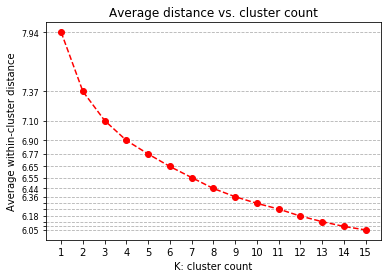

In [152]:
# Show scree plot 
scree_kmeans(clusters, distances)

In [217]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

In [153]:
# Instantiate model with the selected number of clusters
kmeans_13 = KMeans(n_clusters=13)
# Fit the model to PCA-fitted data
kmeans_13 = kmeans_13.fit(X=azdias_pca_40)

# Predict labels on the same general population data
labels = kmeans_13.predict(X=azdias_pca_40)

### Discussion 3.1: Apply Clustering to General Population

Based on the plot shown above, I decided to segment the population into 9 clusters. I intended to apply the "elbow" strategy to find the optimal number of cluster but these particular principal-components data does not show a clear inflection point at which adding new clusters no longer creates a substantial decrease in the average distance. 

The curve does show a clear downward trajectory of the marginal improvement in average distance, which becomes stable in the range of 8 to 11 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [8]:
# Load in the customer demographics data.
filepath = 'Udacity_CUSTOMERS_Subset.csv'
customers = pd.read_csv(filepath, sep=';', quotechar='"')

In [9]:
# Print shape of customers 
print('Shape of {}: {:,} x {} \n'.format(
    filepath, customers.shape[0], customers.shape[1]))
# Print first rows
print('First few rows of {}:'.format(filepath))
customers.head()

Shape of Udacity_CUSTOMERS_Subset.csv: 191,652 x 85 

First few rows of Udacity_CUSTOMERS_Subset.csv:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [156]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [157]:
# Apply preprocessing with cleaning function
customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [159]:
# Print shape of clean customers dataset 
print('Shape of clean customers dataset: {:,} x {}'.format(
     customers.shape[0], customers.shape[1]))

Shape of clean customers dataset: 135,495 x 66


In [161]:
# Feature scaling and PCA transformation
## Apply feature scaling to the customers data
customers_imp = imputer.transform(customers)
customers_scaled = scaler.transform(customers_imp)

In [162]:
## Transform "customers_scaled" using fitted PCA
customers_pca_40 = pca_40.transform(customers_scaled)

In [164]:
## Predict k-means labels on the customer data
labels_customers = kmeans_13.predict(customers_pca_40)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [165]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [171]:
# Compute the proportion of data in each cluster for the general population
# Store in dictionary for population data
clustered_population = dict()
n_pop = len(labels)
for label in set(labels):
    clustered_population[label] = sum(labels == label) / n_pop

In [172]:
# Compute the proportion of data in each cluster for the customer data
# Store in dictionary for customers data
clustered_customers = dict()
n_cust = len(labels_customers)
for label in set(labels_customers):
    clustered_customers[label] = sum(labels_customers == label) / n_cust

In [175]:
# Print the proportions side-by-side
diff_pp = []
print('             Population | Customers')
for label in clustered_population.keys():
    pop_pc = int(round(clustered_population[label]*100))
    cust_pc = int(round(clustered_customers[label]*100))
    diff_pp += [cust_pc - pop_pc]
    print('Cluster {:3.0f}:       {:>3.0f}% |{:>3.0f}%'.format(
        label, pop_pc, cust_pc))

             Population | Customers
Cluster   0:        10% |  9%
Cluster   1:         5% |  3%
Cluster   2:        10% |  7%
Cluster   3:         7% | 12%
Cluster   4:        10% |  1%
Cluster   5:         9% | 17%
Cluster   6:         7% | 33%
Cluster   7:        10% |  1%
Cluster   8:         5% |  4%
Cluster   9:         9% |  7%
Cluster  10:         4% |  3%
Cluster  11:         7% |  1%
Cluster  12:         8% |  1%


In [176]:
# Helper function
def labels_distribution(labels_population, labels_customers):
    """
    Plot the proportion of data in each cluster 
    contrasting the population and customers datasets
    
    INPUT: 
        labels_population - array of label predictions for gen pop
        labels_customers - array of label predictions for customers
    OUTPUT: 
        None - plots the two distributions side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    population = {'labels':labels_population, 
                  'axis':ax1,
                  'xlabel':"General population"}
    customers = {'labels':labels_customers, 
                  'axis':ax2,
                  'xlabel':"Customers"}    
    
    for data_dict in [population, customers]:
        df = pd.DataFrame(dict(labels=data_dict['labels']))
        sns.barplot(ax=data_dict['axis'], data=df, x="labels", y="labels", 
                    estimator=lambda x: len(x) / len(df) * 100)
        data_dict['axis'].set( xlabel=data_dict['xlabel'],
                               ylabel="Proportion of data") 
        data_dict['axis'].grid(which='major', axis='y')

    fig.suptitle('Proportion of data in each cluster')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

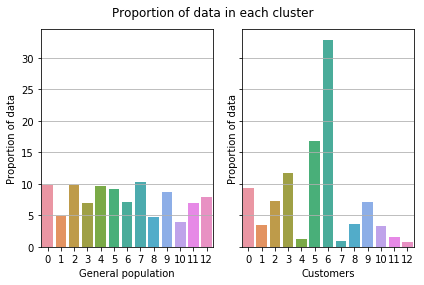

In [177]:
# Plot the proportion of data in each cluster 
# for the general population and the customers 
labels_distribution(labels, labels_customers)

In [178]:
# Use inverse_transform() method of PCA and StandardScaler objects 
# to transform centroids back to the original data space
centroids = kmeans_13.cluster_centers_
centroids = pca_40.inverse_transform(centroids)
centroids = scaler.inverse_transform(centroids)

In [11]:
# Helper function
def centroid_values(features, centroids, over_cluster, under_cluster):
    """
    Print centroid values in original space
    
    INPUT: 
        features - Series of column names
        centroids - array of centroids in original space
        cluster - label for the cluster to print out
    OUTPUT: 
        None - prints pair of feature name and value
    """
    pp_1 = diff_pp[over_cluster]
    pp_2 = diff_pp[under_cluster]
    print('{0:>30}  {1:>20}'.format('-Feature-', '-Cluster centroids-'))
    print('{0:>30} |   ({1:>+d})|    ({2:>+d})|'.format('', pp_1, pp_2))
    for ii in zip(features, centroids[over_cluster], centroids[under_cluster]):
        print('{0:>30} |{1:>8.1f}|{2:>8.1f}|'.format(ii[0], ii[1], ii[2]))
    return None

In [180]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [181]:
centroid_values(features=customers.columns, centroids=centroids, 
                over_cluster=6, under_cluster=4)

                     -Feature-   -Cluster centroids-
                               |   (+26)|    (-9)|
          ALTERSKATEGORIE_GROB |     3.3|     1.8|
                     ANREDE_KZ |     1.0|     2.0|
             FINANZ_MINIMALIST |     4.8|     2.2|
                 FINANZ_SPARER |     1.6|     4.0|
              FINANZ_VORSORGER |     4.2|     2.3|
                FINANZ_ANLEGER |     1.4|     4.4|
         FINANZ_UNAUFFAELLIGER |     2.1|     3.9|
              FINANZ_HAUSBAUER |     2.0|     3.1|
              GREEN_AVANTGARDE |     1.0|     0.2|
                    HEALTH_TYP |     2.1|     2.2|
                RETOURTYP_BK_S |     4.0|     2.5|
                     SEMIO_SOZ |     4.9|     2.7|
                     SEMIO_FAM |     4.7|     3.7|
                     SEMIO_REL |     3.7|     5.2|
                     SEMIO_MAT |     4.0|     4.9|
                    SEMIO_VERT |     6.2|     2.6|
                    SEMIO_LUST |     5.4|     3.4|
                     SEMIO_ER

In [188]:
centroid_values(features=customers.columns, centroids=centroids, 
                over_cluster=6, under_cluster=7)

                     -Feature-   -Cluster centroids-
                               |   (+26)|    (-9)|
          ALTERSKATEGORIE_GROB |     3.3|     1.7|
                     ANREDE_KZ |     1.0|     2.0|
             FINANZ_MINIMALIST |     4.8|     1.2|
                 FINANZ_SPARER |     1.6|     4.3|
              FINANZ_VORSORGER |     4.2|     2.2|
                FINANZ_ANLEGER |     1.4|     4.1|
         FINANZ_UNAUFFAELLIGER |     2.1|     3.7|
              FINANZ_HAUSBAUER |     2.0|     4.2|
              GREEN_AVANTGARDE |     1.0|     0.0|
                    HEALTH_TYP |     2.1|     2.2|
                RETOURTYP_BK_S |     4.0|     2.6|
                     SEMIO_SOZ |     4.9|     3.2|
                     SEMIO_FAM |     4.7|     4.1|
                     SEMIO_REL |     3.7|     5.5|
                     SEMIO_MAT |     4.0|     4.9|
                    SEMIO_VERT |     6.2|     2.3|
                    SEMIO_LUST |     5.4|     3.1|
                     SEMIO_ER

In [189]:
centroid_values(features=customers.columns, centroids=centroids, 
                over_cluster=6, under_cluster=12)

                     -Feature-   -Cluster centroids-
                               |   (+26)|    (-7)|
          ALTERSKATEGORIE_GROB |     3.3|     1.8|
                     ANREDE_KZ |     1.0|     1.0|
             FINANZ_MINIMALIST |     4.8|     1.9|
                 FINANZ_SPARER |     1.6|     4.4|
              FINANZ_VORSORGER |     4.2|     2.1|
                FINANZ_ANLEGER |     1.4|     3.6|
         FINANZ_UNAUFFAELLIGER |     2.1|     3.8|
              FINANZ_HAUSBAUER |     2.0|     3.6|
              GREEN_AVANTGARDE |     1.0|     0.1|
                    HEALTH_TYP |     2.1|     2.3|
                RETOURTYP_BK_S |     4.0|     2.7|
                     SEMIO_SOZ |     4.9|     6.8|
                     SEMIO_FAM |     4.7|     6.8|
                     SEMIO_REL |     3.7|     6.4|
                     SEMIO_MAT |     4.0|     5.2|
                    SEMIO_VERT |     6.2|     6.0|
                    SEMIO_LUST |     5.4|     2.8|
                     SEMIO_ER

In [191]:
centroid_values(features=customers.columns, centroids=centroids, 
                over_cluster=6, under_cluster=5)

                     -Feature-   -Cluster centroids-
                               |   (+26)|    (+8)|
          ALTERSKATEGORIE_GROB |     3.3|     3.3|
                     ANREDE_KZ |     1.0|     1.1|
             FINANZ_MINIMALIST |     4.8|     4.5|
                 FINANZ_SPARER |     1.6|     1.7|
              FINANZ_VORSORGER |     4.2|     4.1|
                FINANZ_ANLEGER |     1.4|     2.2|
         FINANZ_UNAUFFAELLIGER |     2.1|     1.9|
              FINANZ_HAUSBAUER |     2.0|     2.2|
              GREEN_AVANTGARDE |     1.0|     0.0|
                    HEALTH_TYP |     2.1|     2.4|
                RETOURTYP_BK_S |     4.0|     3.7|
                     SEMIO_SOZ |     4.9|     4.7|
                     SEMIO_FAM |     4.7|     4.6|
                     SEMIO_REL |     3.7|     3.6|
                     SEMIO_MAT |     4.0|     3.2|
                    SEMIO_VERT |     6.2|     5.8|
                    SEMIO_LUST |     5.4|     5.0|
                     SEMIO_ER

### Discussion 3.3: Compare Customer Data to Demographics Data

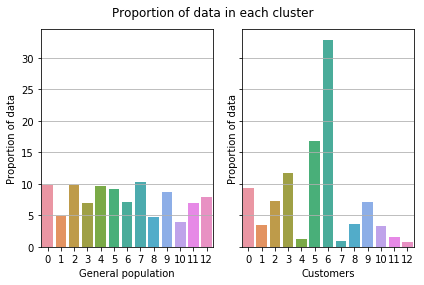

In [190]:
labels_distribution(labels, labels_customers)

The following table shows the proportion of data in each cluster, contrasting the general population and the customer data, side by side:

                     Population | Customer | Diff
        Cluster   0:        10% |    9%    |  -1
        Cluster   1:         5% |    3%    |  -2
        Cluster   2:        10% |    7%    |  -3
        Cluster   3:         7% |   12%    |  +5
        Cluster   4:        10% |    1%    |  -9
        Cluster   5:         9% |   17%    |  +8
        Cluster   6:         7% |   33%    | +26
        Cluster   7:        10% |    1%    |  -9
        Cluster   8:         5% |    4%    |  -1
        Cluster   9:         9% |    7%    |  -2
        Cluster  10:         4% |    3%    |  -1
        Cluster  11:         7% |    1%    |  -6
        Cluster  12:         8% |    1%    |  -7

I found that the best way to evaluate the representativeness of population segments in the customer data was to contrast two clusters at a time: one that is overrepresented to one that is less represented in the customer data. 

Also, I change the names of the clusters to denote whether a given cluster is overrepresented or underrepresented, and by how much. For instance, Cluster 6 above becomes Cluster +26, Cluster 4 becomes Cluster -9(a), Cluster 7 becomes Cluster -9(b), and so on. 

#### Cluster +26 vs. Cluster -9(b)

 To start I consider the most overrepresented segment — Cluster +26 — and contrast it with one of the two most underrepresented — Cluster -9(b). 

Cluster +26 and Cluster -9(b) are centered far from each other with respect to many important features in the original space: estimated age (and other directly associated features), gender, various dimensions of the financial and personality typologies, regional car ownership and housing type, and wealth. 

Specifically, the most overrepresented segment, Cluster +26, is centered on males in their late 40s and 50s; their financial typology is higher on dimensions like investing, and home ownership; their personality typology is substantially higher in dimensions like rational, critical, dominant, combative, religious, and traditional. They live in residential areas with high car ownership and high share of 1-2 family homes; they likely are upper-middle class and have older families.

The most underrepresented segment, Cluster -9(b), is centered on females in their 30s; their financial typology is high on dimensions like "low financial interest"; their personality typology is higher in dimensions like socially-minded and dreamful. They live in apartment buildings in average-to-poor urban regions with lower car ownership. They likely have low income and are lower-middle class; and are single or married without school-age children.

#### Cluster +26 vs. Cluster -9(a)

I then contrast Cluster +26 with the other most underrepresented segment: Cluster -9(a).

Cluster -9(a) seems to be centered on females, who are in a more similar socio-economic and geographic segment as the overrepresented Cluster +26. This groups looks analogous to Cluster -9(b) — analyzed above — with respect to gender and personality type; but in terms of economic measures and housing is actually more similar to Cluster +26.

In summary, Cluster -9(a) is approximately centered on females living in good suburban neighborhoods; they likely are middle-class, married, and have school age children.

#### Cluster +26 vs. Cluster -7

 Cluster -7 is centered on younger men, 30 - 45 years old, who are of similar socioeconomic status as the females in Cluster -9(b). They live in apartment buildings in average-to-poor urban regions. They likely are lower-middle class; and are single or married without school-age children.

 The demographics, other than gender, of these two clusters — Cluster -7 and Cluster -9(b) — are very similar; which leads me to believe that Cluster -7 captures the spouses or other males in the same social and community segment as the females in Cluster -9(b). 

#### Cluster +26 vs. Cluster +8

The other overrepresented segment is Cluster +8, and is centered closely to Cluster +26 (the most overrepresented segment) with respect to age, gender, financial typology, and personality typology. The males in Cluster +8 are less wealthy and live in smaller communities farther from urban centers.

My hypothesis is that Cluster +8 captures very similar individuals than Cluster +26, but instead of living in suburban, upper-middle class neighborhoods, the males in Cluster +8 live in more rural middle-class towns. 

#### Conclusion : Mail-order sales, target demographic 

The analysis above indicates that the clear target demographic for the mail-order sales consists of middle-aged men who show personality and social values that can be said to be traditional. They are more likely to be married with school-age children or have older families. These families likely own their dwellings in single- or dual-family buildings; which are located in upper-middle class suburban neighborhoods or in middle-class rural towns. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.